# **POS označavanje uz primjenu neuronskih mreža**

#### import potrebnih biblioteka/metoda

In [ ]:
!pip install conllu datasets nltk gensim &> /dev/null

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.layers import Dense, Embedding, TimeDistributed

In [ ]:
from io import open
from conllu import parse_incr
from google.colab import files

In [ ]:
import gensim
from gensim.models import Word2Vec, KeyedVectors

## **POS označavanje** (*eng.* POS - *part of speech* - tagging)

> **POS označavanje** ( označavanje dijelova govora) postupak je za označavanje riječi u tekstualnom formatu za određeni dio govora na temelju njegove definicije i konteksta. Odgovorno je za čitanje teksta na jeziku i za dodjeljivanje određenog znaka (dijelovi govora) svakoj riječi. Naziva se i gramatičkim označavanjem. (izvor: https://hr.csstricks.net/8226566-pos-tagging-with-nltk-and-chunking-in-nlp-examples)

![picture](https://drive.google.com/uc?id=19zcwHN45Iwc7tLHiiOHkALCpN5sZ4okD)

### **hr500k** - *korpus sa POS oznakama hrvatskog jezika*

> Ljubešić, N., Agić, Z., & Klubicka, F. (2018). hr500k -A Reference Training Corpus of Croatian. hr500k -A Reference Training Corpus of Croatian (pp. 20–21). https://arrow.tudublin.ie/cgi/viewcontent.cgi?article=1254&context=scschcomcon

> **hr500k:** hrvatski referentni korpus za treniranje od 500 tisuća tokena, segmentiran na razini dokumenta, rečenice i riječi, te označen za morfosintaksu, leme, sintaksu ovisnosti, imenovane entitete i semantičke uloge

> korpus je dostupan u ***CoNLL*** formatu datoteke

## **Analiza i predprocesiranje skupa podataka**

### Učitavanje podataka korpusa za treniranje

In [ ]:
# Import data from local computor

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dev_ner.conllu to dev_ner.conllu
Saving test_ner.conllu to test_ner.conllu
Saving train_ner.conllu to train_ner (1).conllu
User uploaded file "dev_ner.conllu" with length 2815750 bytes
User uploaded file "test_ner.conllu" with length 3583483 bytes
User uploaded file "train_ner.conllu" with length 29413848 bytes


> primjer izgleda podataka za jednu rečenicu iz korpusa: 


![picture](https://drive.google.com/uc?id=1XeKiJqPpZtlCc0lS7tewMRjcE3iS7iOt)


In [ ]:
def read_data(path):
  with open(path, "r", encoding='utf-8') as f:
    sent_id = ''
    text = ''
    tokens = []
    lemmas = []
    xpos_tags = []
    upos_tags = []
    feats = []
    iob_tags = []
    data_id = 0
    for line in f:
      if line and not line == '\n':
        if line.startswith('#'):
          if line.startswith('# sent_id'):
            if tokens:
              yield {
                  'sent_id': sent_id,
                  'text': text,
                  'tokens': tokens,
                  'lemmas': lemmas,
                  'upos_tags': upos_tags,
                  'xpos_tags': xpos_tags,
                  'feats': feats,
                  'iob_tags': iob_tags 
                  }
              tokens = []
              lemmas = []
              upos_tags = []
              xpos_tags = []
              feats = []
              iob_tags = []
              data_id += 1
            sent_id = line.split(' = ')[1].strip()
          elif line.startswith('# text'):
            text = line.split(' = ')[1].strip()
        elif not line.startswith('_'):
          splits = line.split('\t')
          tokens.append(splits[1].strip())
          lemmas.append(splits[2].strip())
          upos_tags.append(splits[3].strip())
          xpos_tags.append(splits[4].strip())
          feats.append(splits[5].strip())
          iob_tags.append(splits[9].strip())

    yield {
        'sent_id': sent_id,
        'text': text,
        'tokens': tokens,
        'lemmas': lemmas,
        'upos_tags': upos_tags,
        'xpos_tags': xpos_tags,
        'feats': feats,
        'iob_tags': iob_tags
        }


In [ ]:
data = read_data("train_ner.conllu")
for i in range(5):
  d = next(data)
  print(d)

{'sent_id': 'train-s1', 'text': 'Proces privatizacije na Kosovu pod povećalom', 'tokens': ['Proces', 'privatizacije', 'na', 'Kosovu', 'pod', 'povećalom'], 'lemmas': ['proces', 'privatizacija', 'na', 'Kosovo', 'pod', 'povećalo'], 'upos_tags': ['NOUN', 'NOUN', 'ADP', 'PROPN', 'ADP', 'NOUN'], 'xpos_tags': ['Ncmsn', 'Ncfsg', 'Sl', 'Npnsl', 'Si', 'Ncnsi'], 'feats': ['Case=Nom|Gender=Masc|Number=Sing', 'Case=Gen|Gender=Fem|Number=Sing', 'Case=Loc', 'Case=Loc|Gender=Neut|Number=Sing', 'Case=Ins', 'Case=Ins|Gender=Neut|Number=Sing'], 'iob_tags': ['O', 'O', 'O', 'B-loc', 'O', 'O']}
{'sent_id': 'train-s2', 'text': 'Kosovo ozbiljno analizira proces privatizacije u svjetlu učestalih pritužbi.', 'tokens': ['Kosovo', 'ozbiljno', 'analizira', 'proces', 'privatizacije', 'u', 'svjetlu', 'učestalih', 'pritužbi', '.'], 'lemmas': ['Kosovo', 'ozbiljno', 'analizirati', 'proces', 'privatizacija', 'u', 'svjetlo', 'učestao', 'pritužba', '.'], 'upos_tags': ['PROPN', 'ADV', 'VERB', 'NOUN', 'NOUN', 'ADP', 'NOUN',

In [ ]:
data = read_data("train_ner.conllu")

In [ ]:
X = [] # tokens
Y = [] # pos tags
F = [] # features
for d in data:
    X.append(d["tokens"])
    Y.append(d['upos_tags'])
    F.append(d['feats'])

In [ ]:
tags = set([word.lower() for sentence in Y for word in sentence])
num_tags  = len(tags)
num_words = len(set([word.lower() for sentence in X for word in sentence]))

In [ ]:
print("Ukupan broj označenih rečenica: {}".format(len(X)))
print("Veličina rječnika: {} riječi".format(num_words))
print("\nUkupan broj oznaka (eng. tags): {} \nOznake:".format(num_tags))
for tag in tags:
    print(tag, end=', ')

Ukupan broj označenih rečenica: 20159
Veličina rječnika: 59297 riječi

Ukupan broj oznaka (eng. tags): 17 
Oznake:
num, pron, cconj, adv, det, noun, intj, x, verb, punct, adj, propn, adp, aux, part, sym, sconj, 

In [ ]:
print("Length of first input sequence : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence : 6
Length of first output sequence : 6


### Vektorizacija skupova **X** (tokens) i **Y**(tags) ( word to integer )

In [ ]:
# encode X
word_tokenizer = Tokenizer()              # instantiate tokeniser
word_tokenizer.fit_on_texts(X)            # fit tokeniser on data

# use the tokeniser to encode input sequence
X_encoded = word_tokenizer.texts_to_sequences(X)

In [ ]:
# encode Y
tag_tokenizer = Tokenizer()               # instantiate tokeniser
tag_tokenizer.fit_on_texts(Y)             # fit tokeniser on data

# use the tokeniser to encode input sequence
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [ ]:
# look at first encoded data point
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X_encoded: ', X_encoded[0], '\n')
print('Y_encoded: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Proces', 'privatizacije', 'na', 'Kosovu', 'pod', 'povećalom'] 

Y:  ['NOUN', 'NOUN', 'ADP', 'PROPN', 'ADP', 'NOUN'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X_encoded:  [510, 2356, 7, 574, 126, 26237] 

Y_encoded:  [1, 1, 5, 8, 5, 1] 



#### Postavljanje jednakih duljina rečenica ( **pad sequences** )

In [ ]:
# sequences greater than 100 in length will be truncated
MAX_SEQ_LENGTH = 100
X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
# print the first sequence
print(X_padded[0], "\n"*3)
print('Y_padded: \n', Y_padded[0], '\n')

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0   510  2356
     7   574   126 26237] 



Y_padded: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 5 8 5 1] 



In [ ]:
# assign padded sequences to X and Y
# X = X_padded
# Y = Y_padded

### Vektorska reprezentacija riječi (eng. **word embeddings**)

#### **word2vec** model

**Word2Vec** se koristi u generiranju
vektorske reprezentacije riječi (engl. embeddings). 

Ovaj model se sastoji od dva pristupa:

*   uzastopna vreća riječi (engl. Continuous Bag of Words CBOW) i
*   preskok grupe znakova (engl. Skip-gram)

(izvor) Vasić, D. ANALIZA I PRIMJENA METODA AUTOMATSKOG SEMANTIČKOG OZNAČAVANJA TEKSTA. https://data.fesb.unist.hr/public/news/KDI_Vasic.pdf

‌

In [ ]:
model = Word2Vec(sentences=X, size=300, iter=100)

In [ ]:
word_vectors = model.wv

In [ ]:
word_vectors.save('vectors.kv')

In [ ]:
word2vec = KeyedVectors.load('vectors.kv')

In [ ]:
# word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

EMBEDDING_SIZE  = 300  
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [ ]:
Y = to_categorical(Y_padded)

In [ ]:
Y.shape

(20159, 100, 18)

In [ ]:
embedding_weights.shape

(59298, 300)

### Podjela na skup za treniranje, validaciju i testiranje

In [ ]:
print(X_padded.shape)
print(Y.shape)

(20159, 100)
(20159, 100, 18)


In [ ]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y, test_size=TEST_SIZE, random_state=4)

In [ ]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [ ]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (14564, 100)
Shape of output sequences: (14564, 100, 18)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (2571, 100)
Shape of output sequences: (2571, 100, 18)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (3024, 100)
Shape of output sequences: (3024, 100, 18)


## **Neuronske mreže**

### **RNN** (eng. *recurrent neural network*)

> Rekurentna (povratna) neuronska mreža (engl.
recurrent neural network RNN) je vrsta umjetne neuronske mreže koja omogućava obradu
nizova ili sekvenci podataka na ulazu i izlazu. Ovo znači da izlaz ne ovisi samo o trenutnom
ulazu već i o prethodnim ulazima i izlazima što je jako čest slučaj u obradi prirodnog jezika.

(izvor) Vasić, D. ANALIZA I PRIMJENA METODA AUTOMATSKOG SEMANTIČKOG OZNAČAVANJA TEKSTA. https://data.fesb.unist.hr/public/news/KDI_Vasic.pdf

#### RNN with arbitrarily initialized, untrainable embeddings

>  In this model, we will initialize the embedding weights arbitrarily. Further, we’ll freeze the embeddings, that is, we won’t allow the network to train them.

In [ ]:
# total number of tags
NUM_CLASSES = Y.shape[2]

In [ ]:
rnn_model = Sequential()

In [ ]:
# create embedding layer — usually the first layer in text problems
# vocabulary size — number of unique words in data
rnn_model.add(Embedding(input_dim = VOCABULARY_SIZE, 
# length of vector with which each word is represented
 output_dim = EMBEDDING_SIZE, 
# length of input sequence
 input_length = MAX_SEQ_LENGTH, 
# False — don’t update the embeddings
 trainable = False 
))

In [ ]:
# add an RNN layer which contains 64 RNN cells
# True — return whole sequence; False — return single output of the end of the sequence
rnn_model.add(SimpleRNN(64, 
 return_sequences=True
))

In [ ]:
# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
#compile model
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [ ]:
# check summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          17789400  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed (TimeDistr  (None, 100, 18)          1170      
 ibuted)                                                         
                                                                 
Total params: 17,813,930
Trainable params: 24,530
Non-trainable params: 17,789,400
_________________________________________________________________


In [ ]:
#fit model
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
114/114 [==============================] - 23s 171ms/step - loss: 0.8403 - acc: 0.8079 - val_loss: 0.5547 - val_acc: 0.8412
Epoch 2/10
114/114 [==============================] - 24s 212ms/step - loss: 0.5386 - acc: 0.8479 - val_loss: 0.4986 - val_acc: 0.8596
Epoch 3/10
114/114 [==============================] - 17s 150ms/step - loss: 0.4760 - acc: 0.8618 - val_loss: 0.4503 - val_acc: 0.8664
Epoch 4/10
114/114 [==============================] - 16s 142ms/step - loss: 0.4324 - acc: 0.8721 - val_loss: 0.4119 - val_acc: 0.8772
Epoch 5/10
114/114 [==============================] - 16s 142ms/step - loss: 0.3982 - acc: 0.8796 - val_loss: 0.3818 - val_acc: 0.8847
Epoch 6/10
114/114 [==============================] - 17s 149ms/step - loss: 0.3709 - acc: 0.8882 - val_loss: 0.3570 - val_acc: 0.8933
Epoch 7/10
114/114 [==============================] - 18s 161ms/step - loss: 0.3481 - acc: 0.8945 - val_loss: 0.3362 - val_acc: 0.8983
Epoch 8/10
114/114 [==============================] - 1

In [ ]:
rnn_model.save('rnn1.h5')

# model_LSTM = load_model('rnn1.h5')

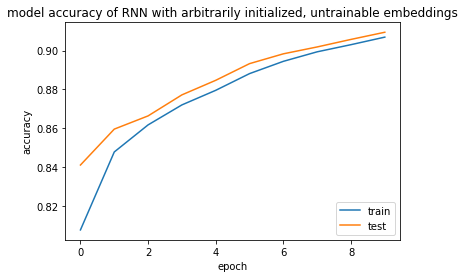

In [ ]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy of RNN with arbitrarily initialized, untrainable embeddings')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.savefig('acc-rnn1.png')
plt.show()

#### RNN with arbitrarily initialized, trainable embeddings ( uninitialised trainable embeddings )

>  In this model, we’ll allow the network to train the embeddings

In [ ]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [ ]:
# check summary of the model
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          17789400  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 18)          1170      
 tributed)                                                       
                                                                 
Total params: 17,813,930
Trainable params: 17,813,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
114/114 [==============================] - 25s 205ms/step - loss: 0.7133 - acc: 0.8413 - val_loss: 0.3264 - val_acc: 0.9216
Epoch 2/10
114/114 [==============================] - 24s 213ms/step - loss: 0.2123 - acc: 0.9476 - val_loss: 0.1440 - val_acc: 0.9642
Epoch 3/10
114/114 [==============================] - 23s 200ms/step - loss: 0.0925 - acc: 0.9805 - val_loss: 0.0863 - val_acc: 0.9769
Epoch 4/10
114/114 [==============================] - 23s 200ms/step - loss: 0.0467 - acc: 0.9915 - val_loss: 0.0669 - val_acc: 0.9799
Epoch 5/10
114/114 [==============================] - 22s 195ms/step - loss: 0.0282 - acc: 0.9942 - val_loss: 0.0594 - val_acc: 0.9813
Epoch 6/10
114/114 [==============================] - 22s 191ms/step - loss: 0.0201 - acc: 0.9954 - val_loss: 0.0562 - val_acc: 0.9817
Epoch 7/10
114/114 [==============================] - 24s 209ms/step - loss: 0.0158 - acc: 0.9961 - val_loss: 0.0548 - val_acc: 0.9820
Epoch 8/10
114/114 [==============================] - 2

In [ ]:
rnn_model.save('rnn2.h5')

# model_LSTM = load_model('rnn2.h5')

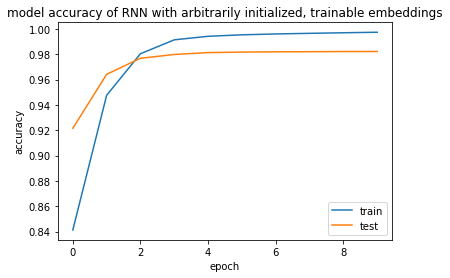

In [ ]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy of RNN with arbitrarily initialized, trainable embeddings')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.savefig('acc-rnn2.png')
plt.show()

#### RNN with trainable word2vec embeddings ( using pre-trained embedding weights )

>  In this experiment, we’ll use word2vec word embeddings and also allow the network to train them further.

In [ ]:
rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [ ]:
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          17789400  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 18)          1170      
 tributed)                                                       
                                                                 
Total params: 17,813,930
Trainable params: 17,813,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
114/114 [==============================] - 23s 192ms/step - loss: 0.5691 - acc: 0.9057 - val_loss: 0.2249 - val_acc: 0.9445
Epoch 2/10
114/114 [==============================] - 21s 188ms/step - loss: 0.1633 - acc: 0.9580 - val_loss: 0.1287 - val_acc: 0.9643
Epoch 3/10
114/114 [==============================] - 20s 177ms/step - loss: 0.0876 - acc: 0.9793 - val_loss: 0.0851 - val_acc: 0.9757
Epoch 4/10
114/114 [==============================] - 21s 181ms/step - loss: 0.0466 - acc: 0.9899 - val_loss: 0.0665 - val_acc: 0.9796
Epoch 5/10
114/114 [==============================] - 21s 182ms/step - loss: 0.0288 - acc: 0.9933 - val_loss: 0.0599 - val_acc: 0.9811
Epoch 6/10
114/114 [==============================] - 20s 178ms/step - loss: 0.0215 - acc: 0.9945 - val_loss: 0.0572 - val_acc: 0.9816
Epoch 7/10
114/114 [==============================] - 20s 177ms/step - loss: 0.0176 - acc: 0.9951 - val_loss: 0.0557 - val_acc: 0.9820
Epoch 8/10
114/114 [==============================] - 2

In [ ]:
rnn_model.save('rnn3.h5')

# model_LSTM = load_model('rnn3.h5')

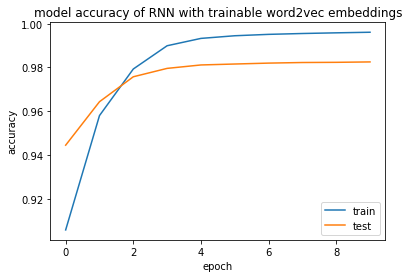

In [ ]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy of RNN with trainable word2vec embeddings')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.savefig('acc-rnn3.png')
plt.show()

### **LSTM** (eng. *long short-term memory*)

> Duga kratkoročna memorija je vrsta RNN arhitekture koja je oblikovana kako bi
modelirala vremenske nizove i njihove dugoročne ovisnosti. LSTM ne koristi klasične
prijenosne funkcije već implementira tzv. LSTM blokove koji se sastoje od nekoliko jedinica.
Ovakvi blokovi se sastoje od troja ili četvora vrata koja kontroliraju tok informacija.

> LSTM mreže se treniraju algoritmom vremenske propagacije unazad (engl.
Backpropagation through time BPTT

(izvor) Vasić, D. ANALIZA I PRIMJENA METODA AUTOMATSKOG SEMANTIČKOG OZNAČAVANJA TEKSTA. https://data.fesb.unist.hr/public/news/KDI_Vasic.pdf

In [ ]:
# create architecture

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
# compile
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [ ]:
# check summary of the model
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          17789400  
                                                                 
 lstm (LSTM)                 (None, 100, 64)           93440     
                                                                 
 time_distributed_3 (TimeDis  (None, 100, 18)          1170      
 tributed)                                                       
                                                                 
Total params: 17,884,010
Trainable params: 17,884,010
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
114/114 [==============================] - 9s 43ms/step - loss: 0.6768 - acc: 0.8994 - val_loss: 0.2762 - val_acc: 0.9340
Epoch 2/10
114/114 [==============================] - 4s 38ms/step - loss: 0.2127 - acc: 0.9434 - val_loss: 0.1687 - val_acc: 0.9508
Epoch 3/10
114/114 [==============================] - 4s 37ms/step - loss: 0.1331 - acc: 0.9618 - val_loss: 0.1138 - val_acc: 0.9675
Epoch 4/10
114/114 [==============================] - 5s 40ms/step - loss: 0.0786 - acc: 0.9830 - val_loss: 0.0778 - val_acc: 0.9775
Epoch 5/10
114/114 [==============================] - 5s 41ms/step - loss: 0.0446 - acc: 0.9905 - val_loss: 0.0629 - val_acc: 0.9800
Epoch 6/10
114/114 [==============================] - 5s 40ms/step - loss: 0.0300 - acc: 0.9927 - val_loss: 0.0573 - val_acc: 0.9812
Epoch 7/10
114/114 [==============================] - 4s 38ms/step - loss: 0.0233 - acc: 0.9942 - val_loss: 0.0545 - val_acc: 0.9817
Epoch 8/10
114/114 [==============================] - 4s 37ms/step - 

In [ ]:
lstm_model.save('lstm.h5')

# model_LSTM = load_model('lstm.h5')

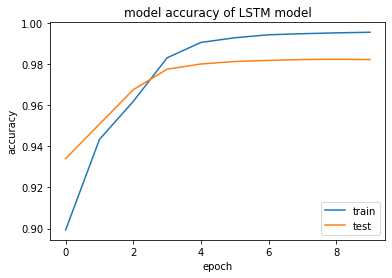

In [ ]:
# visualise training history
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy of LSTM model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.savefig('acc-lstm.png')
plt.show()

### **GRU** (engl. *gated recurrent unit*)

> Još jedan tip rekurentne neuronske mreže je vrata s ponavljajućom jedinicom (engl. Gated
recurrent unit GRU). 

> GRU daje jako dobre rezultate u modeliranju govornog signala i jako
je slična LSTM arhitekturi, pokazuje rezultate jako slične LSTM no učinkovitiji je nad manjim
skupovima podataka. GRU ima manje parametara od LSTM mreže jer ne sadrže izlazna vrata.

(izvor) Vasić, D. ANALIZA I PRIMJENA METODA AUTOMATSKOG SEMANTIČKOG OZNAČAVANJA TEKSTA. https://data.fesb.unist.hr/public/news/KDI_Vasic.pdf

In [ ]:
# create architecture

gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
# check summary of model
gru_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          17789400  
                                                                 
 gru (GRU)                   (None, 100, 64)           70272     
                                                                 
 time_distributed_4 (TimeDis  (None, 100, 18)          1170      
 tributed)                                                       
                                                                 
Total params: 17,860,842
Trainable params: 17,860,842
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
114/114 [==============================] - 7s 44ms/step - loss: 0.6551 - acc: 0.9031 - val_loss: 0.2105 - val_acc: 0.9429
Epoch 2/10
114/114 [==============================] - 5s 41ms/step - loss: 0.1554 - acc: 0.9559 - val_loss: 0.1220 - val_acc: 0.9645
Epoch 3/10
114/114 [==============================] - 5s 42ms/step - loss: 0.0834 - acc: 0.9810 - val_loss: 0.0782 - val_acc: 0.9768
Epoch 4/10
114/114 [==============================] - 5s 42ms/step - loss: 0.0421 - acc: 0.9911 - val_loss: 0.0609 - val_acc: 0.9803
Epoch 5/10
114/114 [==============================] - 5s 41ms/step - loss: 0.0259 - acc: 0.9937 - val_loss: 0.0550 - val_acc: 0.9817
Epoch 6/10
114/114 [==============================] - 4s 39ms/step - loss: 0.0198 - acc: 0.9947 - val_loss: 0.0526 - val_acc: 0.9820
Epoch 7/10
114/114 [==============================] - 4s 37ms/step - loss: 0.0167 - acc: 0.9950 - val_loss: 0.0513 - val_acc: 0.9822
Epoch 8/10
114/114 [==============================] - 4s 37ms/step - 

In [ ]:
gru_model.save('gru.h5')

# model_LSTM = load_model('gru.h5')

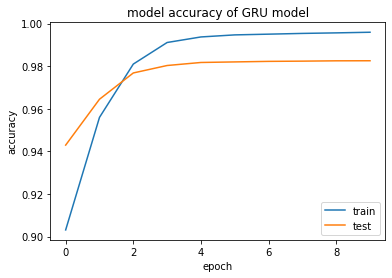

In [ ]:
# visualise training history
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy of GRU model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.savefig("acc-gru.png")
plt.show()

### **Bidirectional LSTM**

In [ ]:
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))   

In [ ]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
# check summary of model
bidirect_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 300)          17789400  
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         186880    
 l)                                                              
                                                                 
 time_distributed_5 (TimeDis  (None, 100, 18)          2322      
 tributed)                                                       
                                                                 
Total params: 17,978,602
Trainable params: 17,978,602
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
114/114 [==============================] - 13s 75ms/step - loss: 0.5384 - acc: 0.9054 - val_loss: 0.1821 - val_acc: 0.9442
Epoch 2/10
114/114 [==============================] - 7s 63ms/step - loss: 0.1442 - acc: 0.9550 - val_loss: 0.1180 - val_acc: 0.9629
Epoch 3/10
114/114 [==============================] - 7s 64ms/step - loss: 0.0870 - acc: 0.9755 - val_loss: 0.0778 - val_acc: 0.9770
Epoch 4/10
114/114 [==============================] - 7s 63ms/step - loss: 0.0458 - acc: 0.9892 - val_loss: 0.0578 - val_acc: 0.9826
Epoch 5/10
114/114 [==============================] - 7s 62ms/step - loss: 0.0268 - acc: 0.9935 - val_loss: 0.0509 - val_acc: 0.9843
Epoch 6/10
114/114 [==============================] - 7s 64ms/step - loss: 0.0192 - acc: 0.9950 - val_loss: 0.0479 - val_acc: 0.9848
Epoch 7/10
114/114 [==============================] - 7s 63ms/step - loss: 0.0153 - acc: 0.9958 - val_loss: 0.0462 - val_acc: 0.9853
Epoch 8/10
114/114 [==============================] - 7s 63ms/step -

In [ ]:
bidirect_model.save('bidir_lstm.h5')

# model = load_model('bidir_lstm.h5')

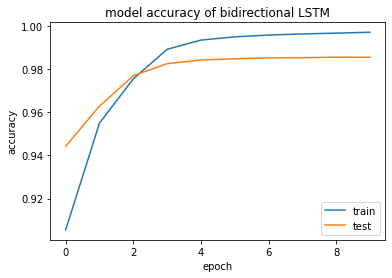

In [ ]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy of bidirectional LSTM')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.savefig("acc-bidir-lstm.png")
plt.show()

## **Evaluacija različitih arhitektura neuronskih mreža**

In [ ]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

95/95 [==============================] - 1s 16ms/step - loss: 0.0562 - acc: 0.9819
Loss: 0.05624203011393547,
Accuracy: 0.9819213151931763


In [ ]:
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

95/95 [==============================] - 1s 9ms/step - loss: 0.0525 - acc: 0.9819
Loss: 0.05253607779741287,
Accuracy: 0.9818551540374756


In [ ]:
loss, accuracy = gru_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

95/95 [==============================] - 1s 10ms/step - loss: 0.0516 - acc: 0.9824
Loss: 0.05155055597424507,
Accuracy: 0.9823545217514038


In [ ]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

95/95 [==============================] - 2s 18ms/step - loss: 0.0467 - acc: 0.9853
Loss: 0.046735409647226334,
Accuracy: 0.9852777719497681


# Izvorni članak:

 > Dayanand, Tanya. ***POS Tagging Using RNN***.  https://www.kaggle.com/code/tanyadayanand/pos-tagging-using-rnn/notebook

‌